# Example: Calculating MMM Using Lightweight MMM

The Lightweight MMM package assists marketers in constructing Bayesian MMM models. It offers features for scaling data, model evaluation, budget optimization, and generating common graphs used in marketing. The model is based on a paper by Google Researcher Jin et al. (2017), with minor modifications to allocate trend and seasonality in the time series data. The structure of the model is demonstrated in its design.

In a simpler term, the model is constructed as below:

$kpi = \alpha + trend + seasonality + mediachannels + other factors$

where:

- $kpi$: volume or value of sales per time period
- $\alpha$: model intercept
- $trend$: function that captures trend in the data
- $seasonality$: function that captures seasonality in the data
- $media channels$: matrix of different media channel activity (typically impressions or costs per time period) which receives transformations depending on the model used
    - Adstock: applies an infinite lag that decreases its weight as time passes.
    - Hill-Adstock: the spending / ad exposure isn't linearly correlated with sales volume; it applies a sigmoid like function for diminishing returns to the output of the adstock function ().
    - Carryover: the effect of the ad exposure isn't immediate; it applies a causal convolution giving more weight to the near values than distant ones.
- $other factors$: other factors that might affect the volume or value of sales

## Flowchart

To calculate MMM for all media channels using Lightweight MMM, we can follow along the flow provided by the documentation below:

!['images.png'](/Users/taufiqurrohman/Documents/ds_marketing_portfolio/marketingmixmodeling/02_lightweight-mmm/images/flowchart.png)

# Demonstration

In [59]:
!pip install --upgrade pip
!pip install -upgrade numba
!pip install --upgrade git+https://github.com/google/lightweight_mmm.git

/Users/taufiqurrohman/anaconda3/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()



Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: -u
  Cloning https://github.com/google/lightweight_mmm.git to /private/var/folders/vm/yq09zwnn4552bd960_dwt5840000gn/T/pip-req-build-6vxsowe3
  Running command git clone --filter=blob:none --quiet https://github.com/google/lightweight_mmm.git /private/var/folders/vm/yq09zwnn4552bd960_dwt5840000gn/T/pip-req-build-6vxsowe3
  Resolved https://github.com/google/lightweight_mmm.git to commit 8ac08a189df55f0e17845a05e3f6dbeb3b13fe20
  Preparing metadata (setup.py) ... done


In [60]:
# load all the libraries we need 

from lightweight_mmm import lightweight_mmm
from lightweight_mmm import preprocessing
from lightweight_mmm import optimize_media
from lightweight_mmm import utils

# if you have a problem when importing plot because of numba library
# uninstall numba using pip uninstall numba, then reinstall it again

from lightweight_mmm import plot

## 0 / Data Exploration

For the data, we will use a dataset from <a href='https://github.com/sibylhe/mmm_stan'>Sibyl He</a> which includes:
- Four years' (209 weeks) records of sales, 
- Media impression 
- Media spending at weekly level.

In [61]:
# download the dataset to our local folder

import requests
import pandas as pd

url = 'https://github.com/sibylhe/mmm_stan/raw/main/data.csv'

response = requests.get(url)

file_path = 'data/data.csv'

with open(file_path, 'wb') as file:
    file.write(response.content)

In [62]:
# we will start reading the data now for the analysis

file_path = 'data/data.csv'
df = pd.read_csv(file_path)

display(df.head(5))

,wk_strt_dt,yr_nbr,qtr_nbr,prd,wk_nbr,wk_in_yr_nbr,mdip_dm,mdip_inst,mdip_nsp,mdip_auddig,...,seas_prd_12,seas_week_40,seas_week_41,seas_week_42,seas_week_43,seas_week_44,seas_week_45,seas_week_46,seas_week_47,seas_week_48
0,2014-08-03,2014,3,7,1,27,4863885,29087520,2421933,692315,...,0,0,0,0,0,0,0,0,0,0
1,2014-08-10,2014,3,7,2,28,20887502,8345120,3984494,475810,...,0,0,0,0,0,0,0,0,0,0
2,2014-08-17,2014,3,7,3,29,11097724,17276800,1846832,784732,...,0,0,0,0,0,0,0,0,0,0
3,2014-08-24,2014,3,7,4,30,1023446,18468480,2394834,1032301,...,0,0,0,0,0,0,0,0,0,0
4,2014-08-31,2014,3,8,1,31,21109811,26659920,3312008,400456,...,0,0,0,0,0,0,0,0,0,0


In [63]:
# check the profile of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 80 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   wk_strt_dt                209 non-null    object 
 1   yr_nbr                    209 non-null    int64  
 2   qtr_nbr                   209 non-null    int64  
 3   prd                       209 non-null    int64  
 4   wk_nbr                    209 non-null    int64  
 5   wk_in_yr_nbr              209 non-null    int64  
 6   mdip_dm                   209 non-null    int64  
 7   mdip_inst                 209 non-null    int64  
 8   mdip_nsp                  209 non-null    int64  
 9   mdip_auddig               209 non-null    int64  
 10  mdip_audtr                209 non-null    int64  
 11  mdip_vidtr                209 non-null    int64  
 12  mdip_viddig               209 non-null    int64  
 13  mdip_so                   209 non-null    int64  
 14  mdip_on   

### Data Description

1. **Media Variables**
    - Media Impression (prefix='mdip_'): impressions of 13 media channels: direct mail, insert, newspaper, digital audio, radio, TV, digital video, social media, online display, email, SMS, affiliates, SEM.
    - Media Spending (prefix='mdsp_'): spending of media channels.
2. **Control Variables**
    - Macro Economy (prefix='me_'): CPI, gas price.
    - Markdown (prefix='mrkdn_'): markdown/discount.
    - Store Count ('st_ct')
    - Retail Holidays (prefix='hldy_'): one-hot encoded.
    - Seasonality (prefix='seas_'): month, with Nov and Dec further broken into to weeks. One-hot encoded.
3. **Sales Variable ('sales')**

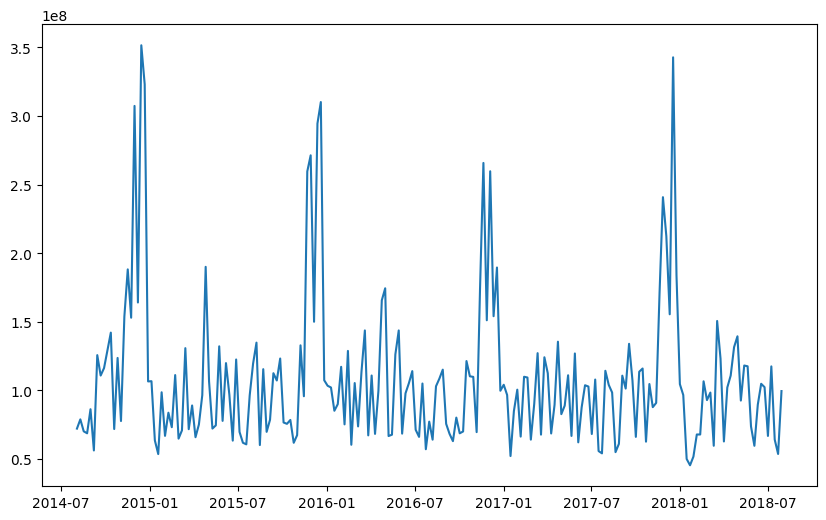

In [64]:
import matplotlib.pyplot as plt

# plot the sales fluctuation

df['wk_strt_dt'] = pd.to_datetime(df['wk_strt_dt'])

plt.figure(figsize=(10,6))
plt.plot(df['wk_strt_dt'], df['sales'])

plt.show()

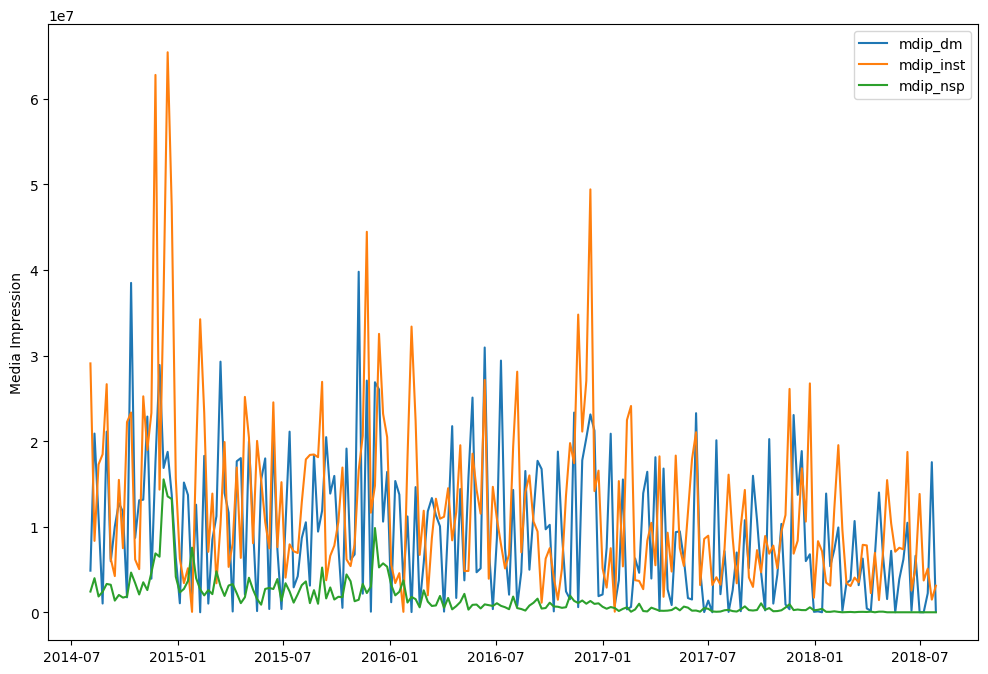

In [65]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# plot each column with 'mdip_' (media impression) in its name with a different color
# only 3 medias, as we're only interested to see the shape of the data
for i, col in enumerate([col for col in df.columns if 'mdip_' in col][:3]):
    plt.plot(df['wk_strt_dt'], df[col], label=f'{col}')

plt.ylabel('Media Impression')
plt.legend()            

plt.show()

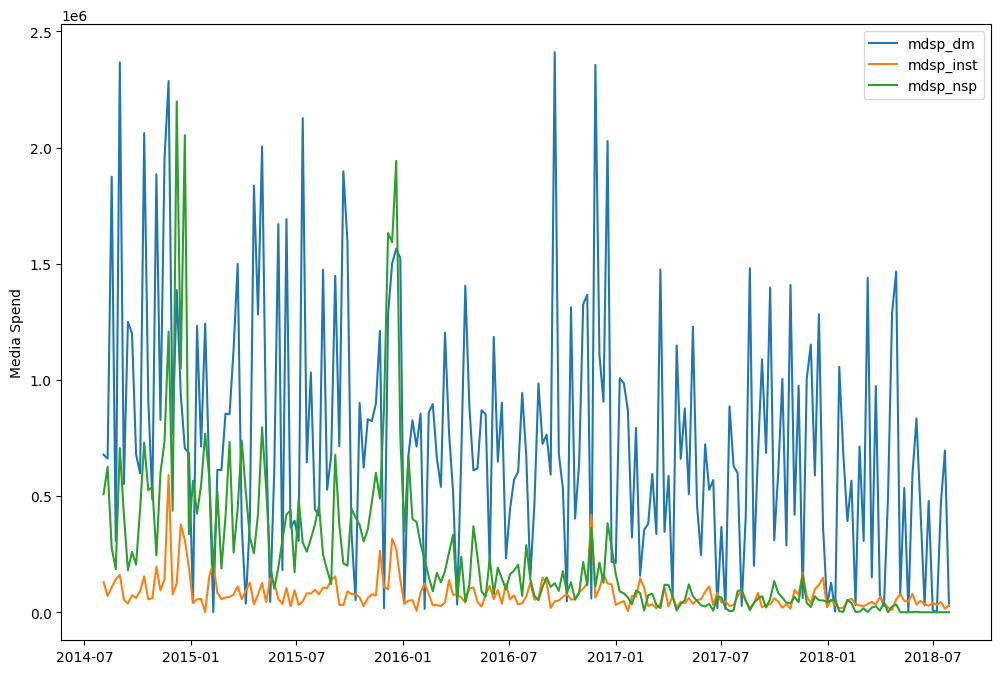

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8)) 

# plot each column with 'mdsp_' (media spend) in its name with a different color
# only 3 medias, as we're only interested to see the shape of the data
for i, col in enumerate([col for col in df.columns if 'mdsp_' in col][:3]):
    plt.plot(df['wk_strt_dt'], df[col], label=f'{col}')

plt.ylabel('Media Spend')
plt.legend()            

plt.show()

## 1 / Data Preparation

For this example, we will use each media impression (*mdip*) data and it's effect to the sales. Preparation including:
- Cleaning the data
- Separating data into media_data, control_var, costs_var, and sales 
- Scaling the data; Bayesian techniques work well if the input data is small scale. 
- We should not center variables at 0. Sales and media should have a lower bound of 0.

In [67]:
# media cost has different length with the media data (number of n_media is different)
# n_media in cost data should be equal to n_media in media data

print('number of media cost data:', len([col for col in df.columns if 'mdsp_' in col]))
print('number of media impression data:', len([col for col in df.columns if 'mdip' in col]))

number of media cost data: 10
number of media impression data: 13


In [68]:
# check which column that doesn't exist in cost data

mdsp_cols = [col.split('_')[1] for col in df.columns if 'mdsp_' in col]
not_exist = [col for col in df.columns if 'mdip' in col and col.split('_')[1] not in mdsp_cols]

not_exist

['mdip_em', 'mdip_sms', 'mdip_aff']

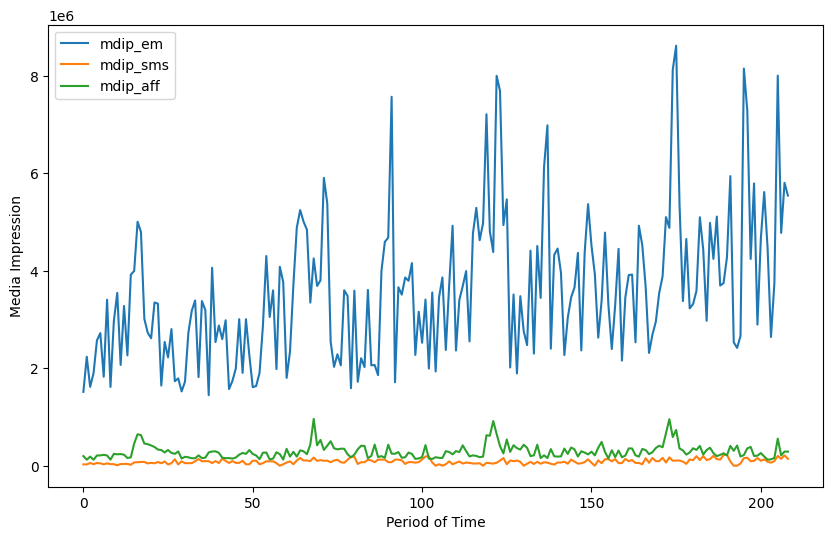

In [69]:
# plot to see the effect

df[not_exist].plot(figsize=(10,6))
plt.xlabel('Period of Time')
plt.ylabel('Media Impression')

plt.show()

In [73]:
# the number of media impression is small compared to the other channnels
# we can omit these variables for the sake of simplicity of the model

cols_to_keep = [col for col in df.columns if col not in not_exist]
df = df[cols_to_keep]

In [75]:
# specify all variables we need
# - media variables: spend or specific data each channel (impression, clicks, etc.)
# - control variables: seasonality, holiday, etc.
# - costs: total cost per media unit per channel.
# - y variable: sales

# media data
media_data = df[[col for col in df.columns if 'mdip_' in col]].to_numpy()

# control variables
control_var = df[[col for col in df.columns if 'hldy_' in col or 'seas_' in col]].to_numpy()

# costs variable
costs_var = df[[col for col in df.columns if 'mdsp' in col]].sum().to_numpy()

# sales data / y variable
sales = df['sales'].to_numpy()

In [76]:
# split data to train and test (like machine learning approach)
# only for media data, control variable, and sales. no need for the cost, as it's the sum over the period

data_size = media_data.shape[0]
test_size = 24
split_point = data_size - test_size

# media data
media_data_train = media_data[:split_point, ...]  # ... is used when we're slicing numpy array or pandas dataframe
media_data_test = media_data[split_point:, ...]

# control variable
control_train = control_var[:split_point, ...]
control_test = control_var[split_point:, ...]

# sales data
sales_train = sales[:split_point, ...]

In [80]:
# scale the data using scalar method, included with lightweight mmm
# normalize the data by it's mean

import jax.numpy as jnp

media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
control_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
costs_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean, multiply_by=0.15)
sales_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)

media_data_train = media_scaler.fit_transform(media_data_train)
control_train = control_scaler.fit_transform(control_train)
costs_var = costs_scaler.fit_transform(costs_var)
sales_train = sales_scaler.fit_transform(sales_train)

In [81]:
print(media_data_train[0][:5])
print(control_train[0][:5])
print(sales_train[:5])
print(costs_var)

[0.47769013 2.1971285  1.3274987  0.7192561  1.6641729 ]
[0. 0. 0. 0. 0.]
[0.6583399  0.71995413 0.64024603 0.6271917  0.7875321 ]
[0.48390394 0.050752   0.16256173 0.00245496 0.07829537 0.10738472
 0.01181135 0.0651431  0.13784897 0.39984393]


## 2 / Training the Model

!['carryover-vs-hill.png'](images/carryover-vs-hill.png)

**There are three models we can use:**
- adstock: applies an infinite lag that decreases its weight as time passes. 
- hill_adstock: the spending / ad exposure isn't linearly correlated with sales volume; it applies a sigmoid like function for diminishing returns to the output of the adstock function (). *-> the fastest one*
- carryover: the effect of the ad exposure isn't immediate; it applies a causal convolution giving more weight to the near values than distant ones. *-> usually more accurate*

In [82]:
mmm = lightweight_mmm.LightweightMMM(model_name='carryover')  # use carryover effect on this

### Parameteres we can pass to mmm.fit()

- media – Media input data. Media data must have either 2 dims for national model or 3 for geo models.

- media_prior – Costs of each media channel. The number of cost values must be equal to the number of media channels.

- target – Target KPI to use, like for example sales.

- extra_features – Other variables to add to the model.

- degrees_seasonality – Number of degrees to use for seasonality. Default is 2.

- seasonality_frequency – Frequency of the time period used. Default is 52 as in 52 weeks per year.

- weekday_seasonality – In case of daily data, also estimate seven weekday parameters.

- media_names – Names of the media channels passed.

- number_warmup – Number of warm up samples. Default is 1000.

- number_samples – Number of samples during sampling. Default is 1000.

- number_chains – Number of chains to sample. Default is 2.

- target_accept_prob – Target acceptance probability for step size in the NUTS sampler. Default is .85.

- init_strategy – Initialization function for numpyro NUTS. The available options can be found in https://num.pyro.ai/en/stable/utilities.html#initialization-strategies. Default is numpyro.infer.init_to_median.

- custom_priors – The custom priors we want the model to take instead of the default ones. Refer to the full documentation on custom priors for details.

- seed – Seed to use for PRNGKey during training. For better replicability run all different trainings with the same seed.

In [86]:
# fitting the model

seed = 42
number_warmup = 1000
number_samples = 1000
media_names = [col for col in df.columns if 'mdip_' in col]

mmm.fit(media=media_data_train,
        media_prior=costs_var,
        target=sales_train,
        extra_features=control_train,
        media_names=media_names,
        number_warmup=number_warmup,
        number_samples=number_samples,
        seed=seed
        )

/Users/taufiqurrohman/anaconda3/lib/python3.10/site-packages/lightweight_mmm/lightweight_mmm.py:358: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(
sample: 100%|██████████| 2000/2000 [07:15<00:00,  4.59it/s, 1023 steps of size 1.82e-03. acc. prob=0.92]


## 3 / Model Diagnostic

### Convergence check

In [90]:
# print summary -> coefficient, ci, etc.
# r_hat for all variables should be under 1.1
# if more, then adjust the number warmup, samples, or change the model name

mmm.print_summary()


                                 mean       std    median      5.0%     95.0%     n_eff     r_hat
ad_effect_retention_rate[0]      0.54      0.29      0.55      0.12      1.00    625.26      1.00
ad_effect_retention_rate[1]      0.49      0.30      0.49      0.06      0.96    483.54      1.00
ad_effect_retention_rate[2]      0.50      0.30      0.49      0.09      1.00    441.47      1.01
ad_effect_retention_rate[3]      0.51      0.29      0.52      0.09      0.98    688.61      1.00
ad_effect_retention_rate[4]      0.55      0.29      0.55      0.14      1.00    371.09      1.00
ad_effect_retention_rate[5]      0.29      0.26      0.20      0.00      0.73    143.71      1.02
ad_effect_retention_rate[6]      0.51      0.29      0.52      0.10      1.00    685.33      1.00
ad_effect_retention_rate[7]      0.53      0.29      0.53      0.12      0.99    486.17      1.00
ad_effect_retention_rate[8]      0.52      0.30      0.53      0.11      1.00    446.24      1.00
ad_effect_retention

### Fitting check

- Will return us with a plot, Bayesian R-squared, and Mean Absolute Percentage Error (MAPE).
- MAPE is a metric to evaluate the accuracy of a forecasting model. MAPE calculates the percentage difference between predicted and actual values, averaged across all predictions.
- The golden standard in the industry is that MAPE below 10% is an acceptable rate.
- Bayesian $R^2$ is a metric used to evaluate the goodness of fit of a Bayesian regression model. It is similar to the traditional coefficient of determination $R^2$, but it takes into account the uncertainty in the model parameters. 

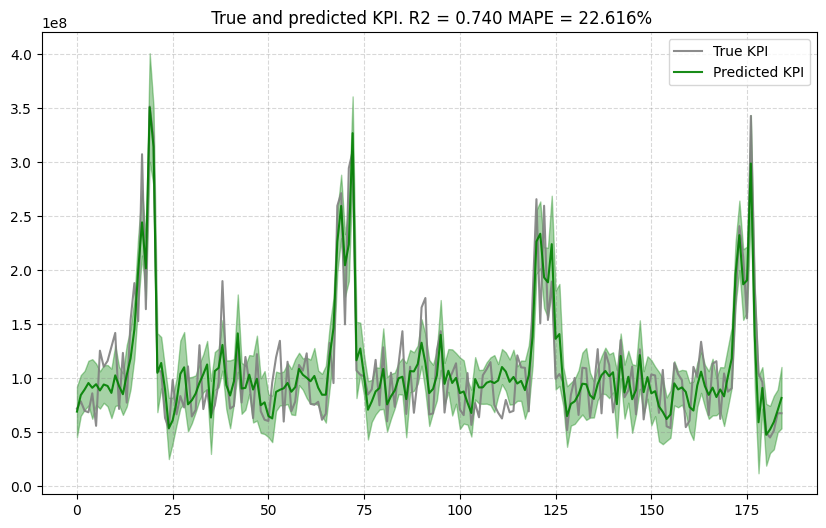

In [96]:
fig = plot.plot_model_fit(media_mix_model=mmm,            # pass the mmm model
                          target_scaler=sales_scaler      # pass the y-variable scaler if we want to get the unscaled data
                          )

# plot.plot_model_fit will return matplotlib.figure.Figure object
# we can resize the figure using fig.set_size_inches
fig.set_size_inches(10, 6)                                  

fig

### Parameter estimate check

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1mNo implementation of function Function(<function histogram at 0x110b21e10>) found for signature:
 
 >>> histogram(readonly buffer(float32, 1d, C), bins=int64, range=UniTuple(readonly buffer(float32, 0d, C) x 2))
 
There are 2 candidate implementations:
[1m  - Of which 2 did not match due to:
  Overload in function 'np_histogram': File: numba/np/arraymath.py: Line 3907.
    With argument(s): '(readonly buffer(float32, 1d, C), bins=int64, range=UniTuple(readonly buffer(float32, 0d, C) x 2))':[0m
[1m   Rejected as the implementation raised a specific error:
     TypingError: Failed in nopython mode pipeline (step: nopython frontend)
   [1m[1m[1mNo implementation of function Function(<function linspace at 0x110554c10>) found for signature:
    
    >>> linspace(readonly buffer(float32, 0d, C), readonly buffer(float32, 0d, C), int64)
    
   There are 2 candidate implementations:
   [1m      - Of which 2 did not match due to:
         Overload of function 'linspace': File: numba/np/arrayobj.py: Line 4817.
           With argument(s): '(readonly buffer(float32, 0d, C), readonly buffer(float32, 0d, C), int64)':[0m
   [1m       No match.[0m
   [0m
   [0m[1mDuring: resolving callee type: Function(<function linspace at 0x110554c10>)[0m
   [0m[1mDuring: typing of call at /Users/taufiqurrohman/anaconda3/lib/python3.10/site-packages/numba/np/arraymath.py (3948)
   [0m
   [1m
   File "../../../../anaconda3/lib/python3.10/site-packages/numba/np/arraymath.py", line 3948:[0m
   [1m            def histogram_impl(a, bins=10, range=None):
                   <source elided>
   
   [1m                bins_array = np.linspace(bin_min, bin_max, bins + 1)
   [0m                [1m^[0m[0m
[0m
  raised from /Users/taufiqurrohman/anaconda3/lib/python3.10/site-packages/numba/core/typeinfer.py:1091
[0m
[0m[1mDuring: resolving callee type: Function(<function histogram at 0x110b21e10>)[0m
[0m[1mDuring: typing of call at /Users/taufiqurrohman/anaconda3/lib/python3.10/site-packages/arviz/stats/density_utils.py (987)
[0m
[1m
File "../../../../anaconda3/lib/python3.10/site-packages/arviz/stats/density_utils.py", line 987:[0m
[1mdef histogram(data, bins, range_hist=None):
    <source elided>
    """
[1m    hist, bin_edges = np.histogram(data, bins=bins, range=range_hist)
[0m    [1m^[0m[0m


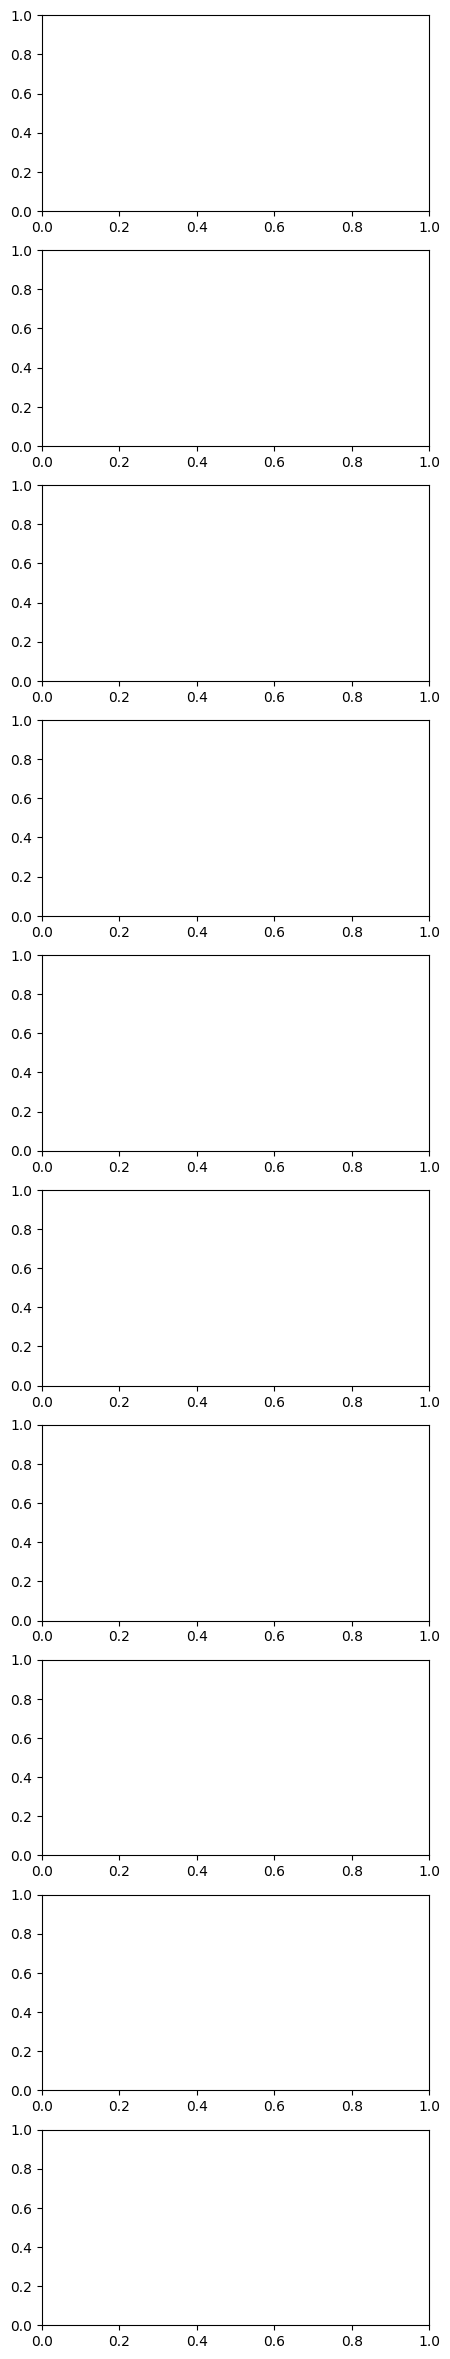

In [103]:
import arviz
import numba

# got some errors about library version issue
# uninstall lightweight_mmm, arviz, numpy, and numba, then reinstall lightweight_mmm which automatically installed arviz and numpy for me.
# https://github.com/google/lightweight_mmm/issues/267

plot.plot_media_channel_posteriors(media_mix_model=mmm, channel_names=[col for col in df.columns if 'mdip_' in col])

### Predictive check

- Using the remaining test data to check whether our model can generalize to the unseen data

In [107]:
new_predictions = mmm.predict(media=media_scaler.transform(media_data_test),          # transform using the fitted transformer
                              extra_features=control_scaler.transform(control_test),  # same case for the extra features
                              seed=seed
                              )

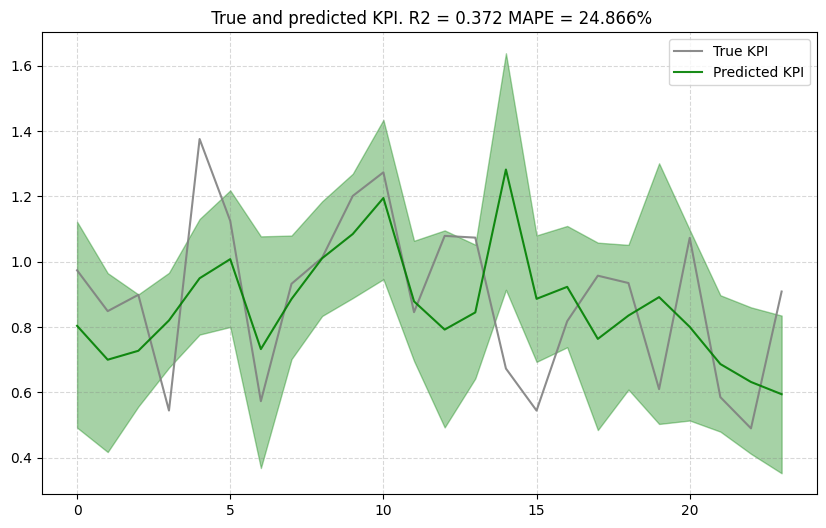

In [129]:
fig = plot.plot_out_of_sample_model_fit(out_of_sample_predictions=new_predictions,                        # pass the new prediction here
                                        out_of_sample_target=sales_scaler.transform(sales[split_point:])  # we haven't splitted the sales data, so here we split it
                                        )
fig.set_size_inches(10, 6)                                  
fig

### Media insights

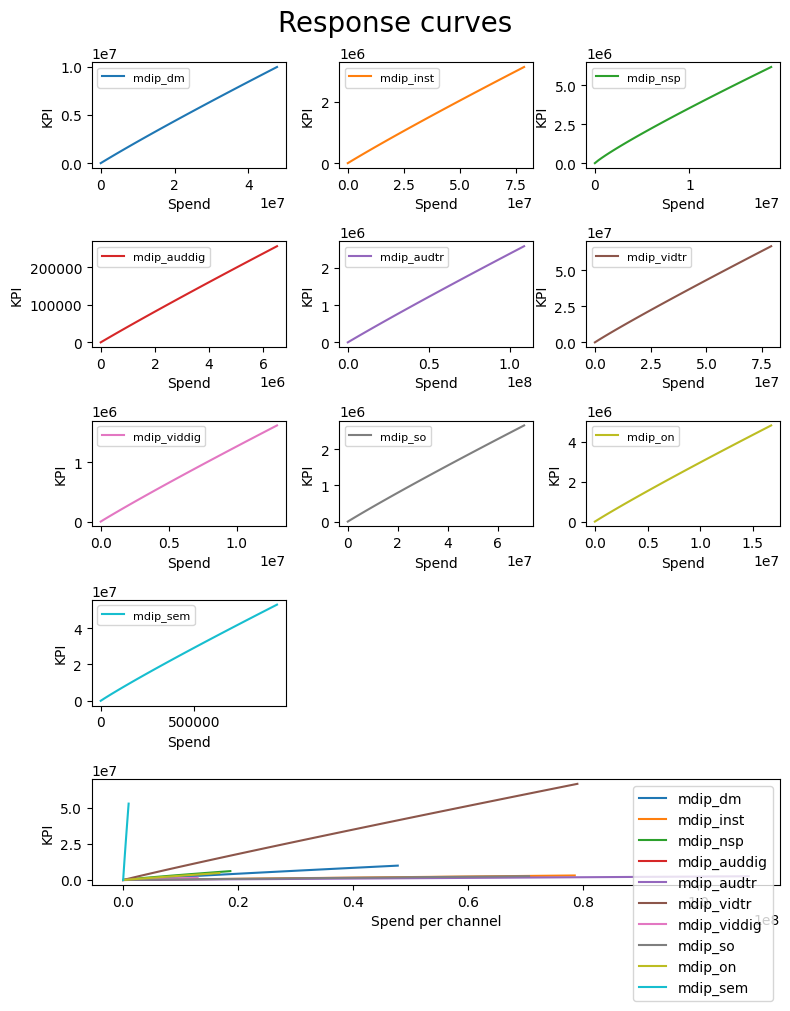

In [111]:
plot.plot_response_curves(media_mix_model=mmm, 
                          media_scaler=media_scaler, 
                          target_scaler=sales_scaler
                          )

- We can now call **mmm.get_posterior_metrics** to extract the media effectiveness and ROI estimation.
- media_effect_hat is the media effectiveness estimation and roi_hat is the ROI estimation. 

In [113]:
media_effect_hat, roi_hat = mmm.get_posterior_metrics(target_scaler=sales_scaler,
                                                      cost_scaler=costs_scaler,
                                                      )

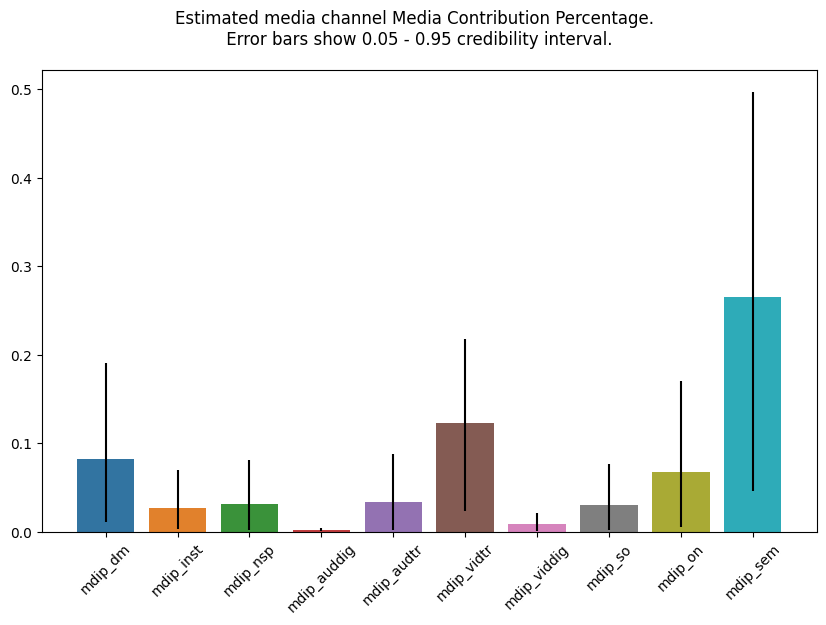

In [121]:
# plot for media contribution percentage to the sales

fig = plot.plot_bars_media_metrics(metric=media_effect_hat, 
                                   channel_names=[col for col in df.columns if 'mdip_' in col],
                                   metric_name='Media Contribution Percentage'
                                   )
fig.set_size_inches(10, 6)
fig

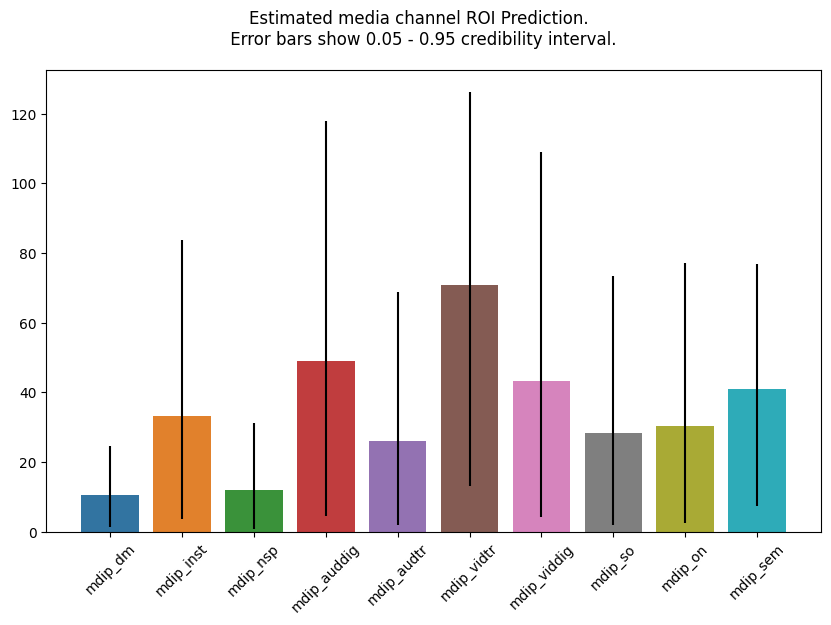

In [122]:
# plot for the roi estimation

fig = plot.plot_bars_media_metrics(metric=roi_hat, 
                                   channel_names=[col for col in df.columns if 'mdip_' in col],
                                   metric_name='ROI Prediction'
                                   )
fig.set_size_inches(10, 6)
fig

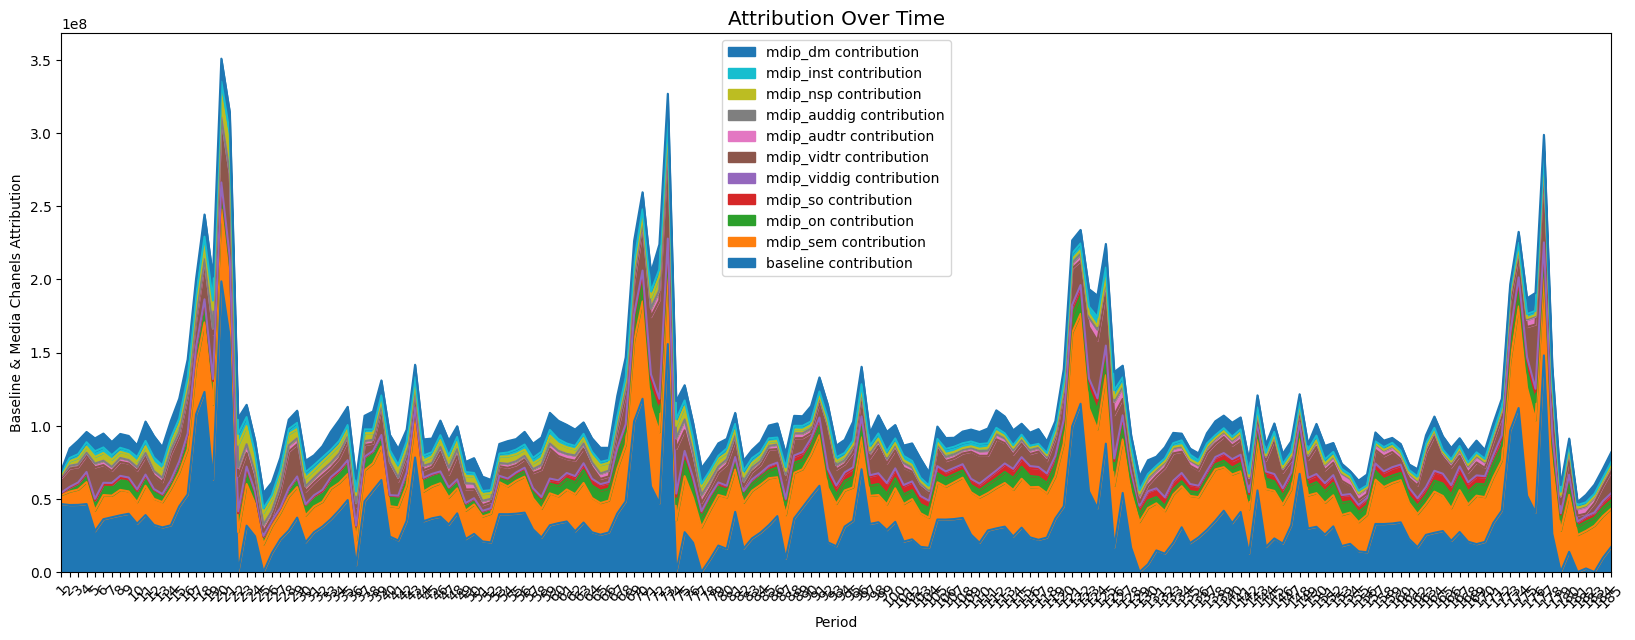

In [127]:
plot.plot_media_baseline_contribution_area_plot(media_mix_model=mmm,
                                                target_scaler=sales_scaler,
                                                channel_names=[col for col in df.columns if 'mdip_' in col]
                                                )

## 4 / Optimization

- Lightweight MMM is also bundled with optimization feature. 
- To optimize sales, we aim to maximize the impact of media inputs while keeping the total media cost constant. 
- We can also set reasonable limits (+- x%) on each media input. 
- Our optimization focuses on channels, not time periods. 

To run the optimization, the key parameters required are:

- **n_time_periods:** The number of time periods you wish to simulate (e.g., optimize for the next 10 weeks if your model was trained on weekly data).
- **media_mix_model:** The trained model.
- **budget:** The budget you intend to allocate for the next n_time_periods.
- **extra_features:** Any additional features used for training for the upcoming n_time_periods.
- **prices:** Price per unit of media for each channel.
- **media_gap:** The gap in media data between the end of the training data and the start of the out-of-sample media provided. For example, if 100 weeks of data were used for training and prediction starts 2 months after the training data finished, you need to provide the 8 weeks missing between the training data and the prediction data. This ensures that data transformations (such as adstock, carryover, etc.) can be applied correctly.

In [228]:
# optimize for the 3 months ahead (12 weeks)
# price, assuming that every media channel spend is $3 for 1,000 impression (CPM of $3)
# budget, for a given number of time periods based on the prices of media inputs and the mean total cost per time period.

n_time_periods = 12     
prices = jnp.full(mmm.n_media_channels, 1)

total_cost = df[[col for col in df.columns if 'mdsp' in col]].sum().to_numpy()
budget = jnp.sum(jnp.dot(prices, total_cost.mean(axis=0))) * n_time_periods

In [229]:
# start optimizing based on all parameters we pass

solution, kpi_without_optim, previous_budget_allocation = optimize_media.find_optimal_budgets(
    n_time_periods=n_time_periods,
    media_mix_model=mmm,
    budget=budget,
    prices=prices,
    media_scaler=media_scaler,
    target_scaler=sales_scaler,
    seed=seed,
    # faulty message, turn this one to increase the upper bound of the constraints for optimization
    # but it might take much longer to finish
    # bounds_upper_pct=20
    )

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -1938968025.262183
            Iterations: 5
            Function evaluations: 21
            Gradient evaluations: 1


In [230]:
# show the optimal budget for each time period
# by multiply the solution with the solution we have

optimal_budget_allocation = 1 * solution.x
optimal_budget_allocation

array([1.46622128e+08, 1.90639904e+08, 2.62718440e+07, 1.38606200e+07,
       3.26891904e+08, 1.45757552e+08, 1.67345140e+07, 1.88267360e+08,
       6.93756160e+07, 3.08880300e+06])

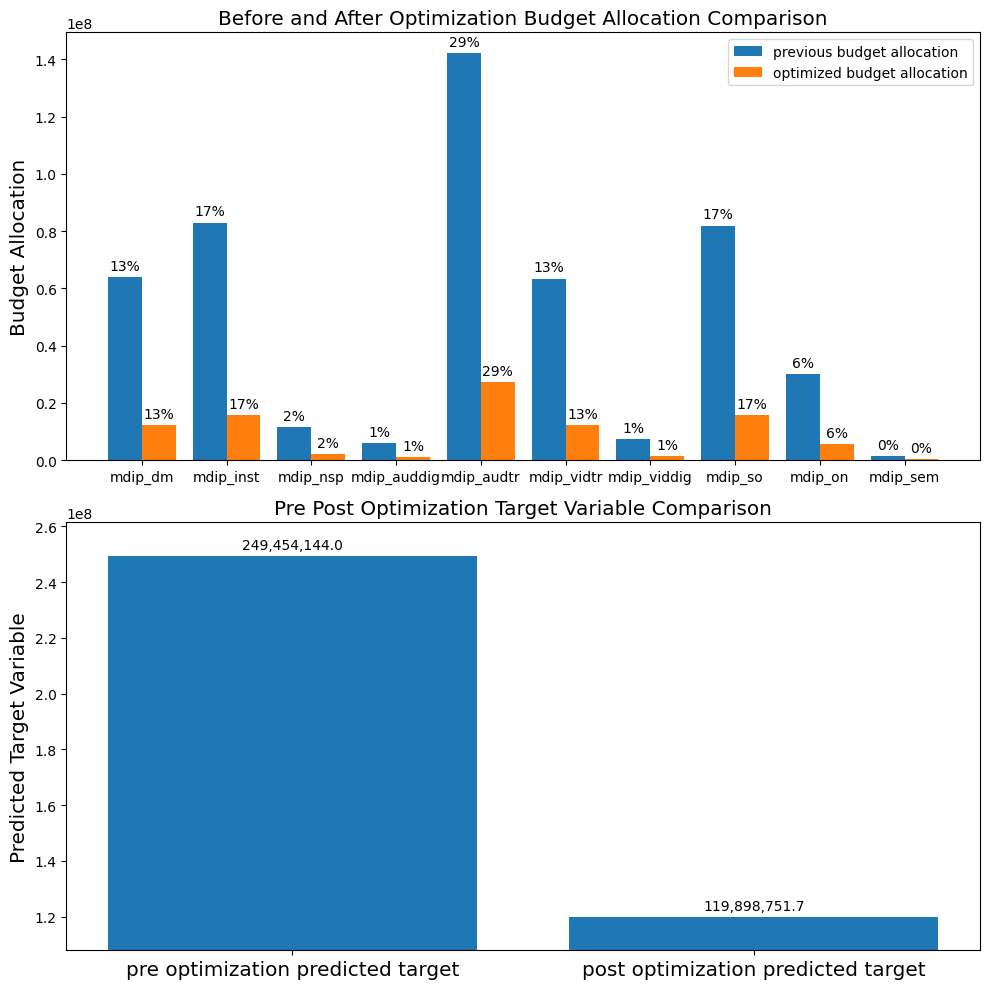

In [223]:
# pass all the variables to see the comparison before and after we optimize

# NOTES!
# the optimization we tried hasn't converge due to low upper bound
# it will take some time to finish if we try to increase the upper bound
# thus, the following plot doesn't show the optimized version
# but, it's only showing you on how to do it using lightweight mmm 

plot.plot_pre_post_budget_allocation_comparison(media_mix_model=mmm,
                                                kpi_with_optim=solution['fun'],
                                                kpi_without_optim=kpi_without_optim,
                                                optimal_buget_allocation=optimal_budget_allocation,
                                                previous_budget_allocation=previous_budget_allocation,
                                                figure_size=(10, 10)
                                                )

# All-in-all

The Lightweight MMM library is a great choice for identifying the most effective media and optimizing spending for each media channel using a sophisticated model developed by Google Researchers. It handles all the backend processes, so you don't need to construct the Bayesian model of MMM model yourself.

# References

- Model Documentation: https://lightweight-mmm.readthedocs.io/en/latest/index.html
- Model's Github page: https://github.com/google/lightweight_mmm
- Research paper: https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/46001.pdf